In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import re
from liftover import get_lifter
import seaborn as sns
import networkx as nx
import pickle
sys.path.append("/n/holystore01/LABS/liau_lab/Users/heejinroh/TDAC_seq/tdac_seq")
from ddda_dataset import *
%matplotlib inline
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec

In [2]:
# Create a folder to save plots
working_dir = "/n/holystore01/LABS/liau_lab/Users/heejinroh/Yan_minimap/analysis/HJR231"
plot_dir = os.path.join("/n/holystore01/LABS/liau_lab/Users/heejinroh/Yan_minimap/analysis/HJR231/", "plot")
os.system("mkdir -p " + plot_dir)

# Create a dictionary for reference regions
ref_range_dict = {
    'HJR231': ('chr9', 107420790, 107423552)
}

# Initialize ddda_dataset
ddda_data = ddda_dataset(
    ID = "HJR_231_3", 
    region_dict = ref_range_dict, 
    genome_file = "/n/holystore01/LABS/liau_lab/Users/heejinroh/Genome/GCA_000001405.15_GRCh38_no_alt_analysis_set.fna", 
    fastq_file = "/n/holystore01/LABS/liau_lab/Users/heejinroh/HJR231_050624/HJR231_1/HJR231_1_merged.fastq.gz", 
    working_dir =  "/n/holystore01/LABS/liau_lab/Users/heejinroh/Yan_minimap/analysis/HJR231"
)

# Load DddA bias model
with open("/n/holystore01/LABS/liau_lab/Users/heejinroh/Yan_minimap/code/bias_dict.pkl", "rb") as f:
    ddda_data.bias_model = pickle.load(f)



Loading reference genome
Extracting sequences for each locus


In [3]:
# Align reads
gap_threshold = 500
ddda_data.align_reads(
    start_gap_threshold = gap_threshold,
    end_gap_threshold = gap_threshold
)

Computing sequence bias


100%|██████████| 84637/84637 [01:25<00:00, 988.74it/s] 


70217 reads aligned. 14420 reads unaligned


In [6]:
locus = "HJR231"

In [44]:
with open('/n/holystore01/LABS/liau_lab/Users/heejinroh/Yan_minimap/analysis/HJR231/ddda_data_HJR231_1.pkl', 'wb') as f:
    pickle.dump(ddda_data , f)

In [3]:
with open('/n/holystore01/LABS/liau_lab/Users/heejinroh/Yan_minimap/analysis/HJR231/ddda_data_HJR231_1.pkl', 'rb') as f:
    ddda_data = pickle.load(f)

In [7]:
min_num=10000
undel_read_ids=np.random.choice(np.array(ddda_data.read_ids[locus]), min_num, replace=False)

In [8]:
undel_read_ids = ddda_data.dedup_reads(
    locus = locus, 
    read_ids = undel_read_ids
)

100%|██████████| 10000/10000 [00:01<00:00, 9901.93it/s]
10000it [00:00, 1127107.19it/s]


In [9]:
undel_read_inds = np.array([ddda_data.read_ids[locus].index(i) for i in undel_read_ids])

In [10]:
selected_read_inds = undel_read_inds
selected_reads = np.array(ddda_data.read_ids[locus])[selected_read_inds]
selected_del_flags = np.zeros(len(undel_read_inds))
selection_dict = {"HJR250_19":selected_reads}

In [11]:
strands =ddda_data.read_strands[locus][selected_read_inds]
CtoT_inds = selected_read_inds[strands==0]
GtoA_inds = selected_read_inds[strands==1]

CtoT_reads=np.array(ddda_data.read_ids[locus])[CtoT_inds]
GtoA_reads=np.array(ddda_data.read_ids[locus])[GtoA_inds]

CtoT_edits = np.array(ddda_data.edit_dict[locus][CtoT_inds, :].todense())
GtoA_edits = np.array(ddda_data.edit_dict[locus][GtoA_inds, :].todense())
edits = np.array(ddda_data.edit_dict[locus][selected_read_inds, :].todense())

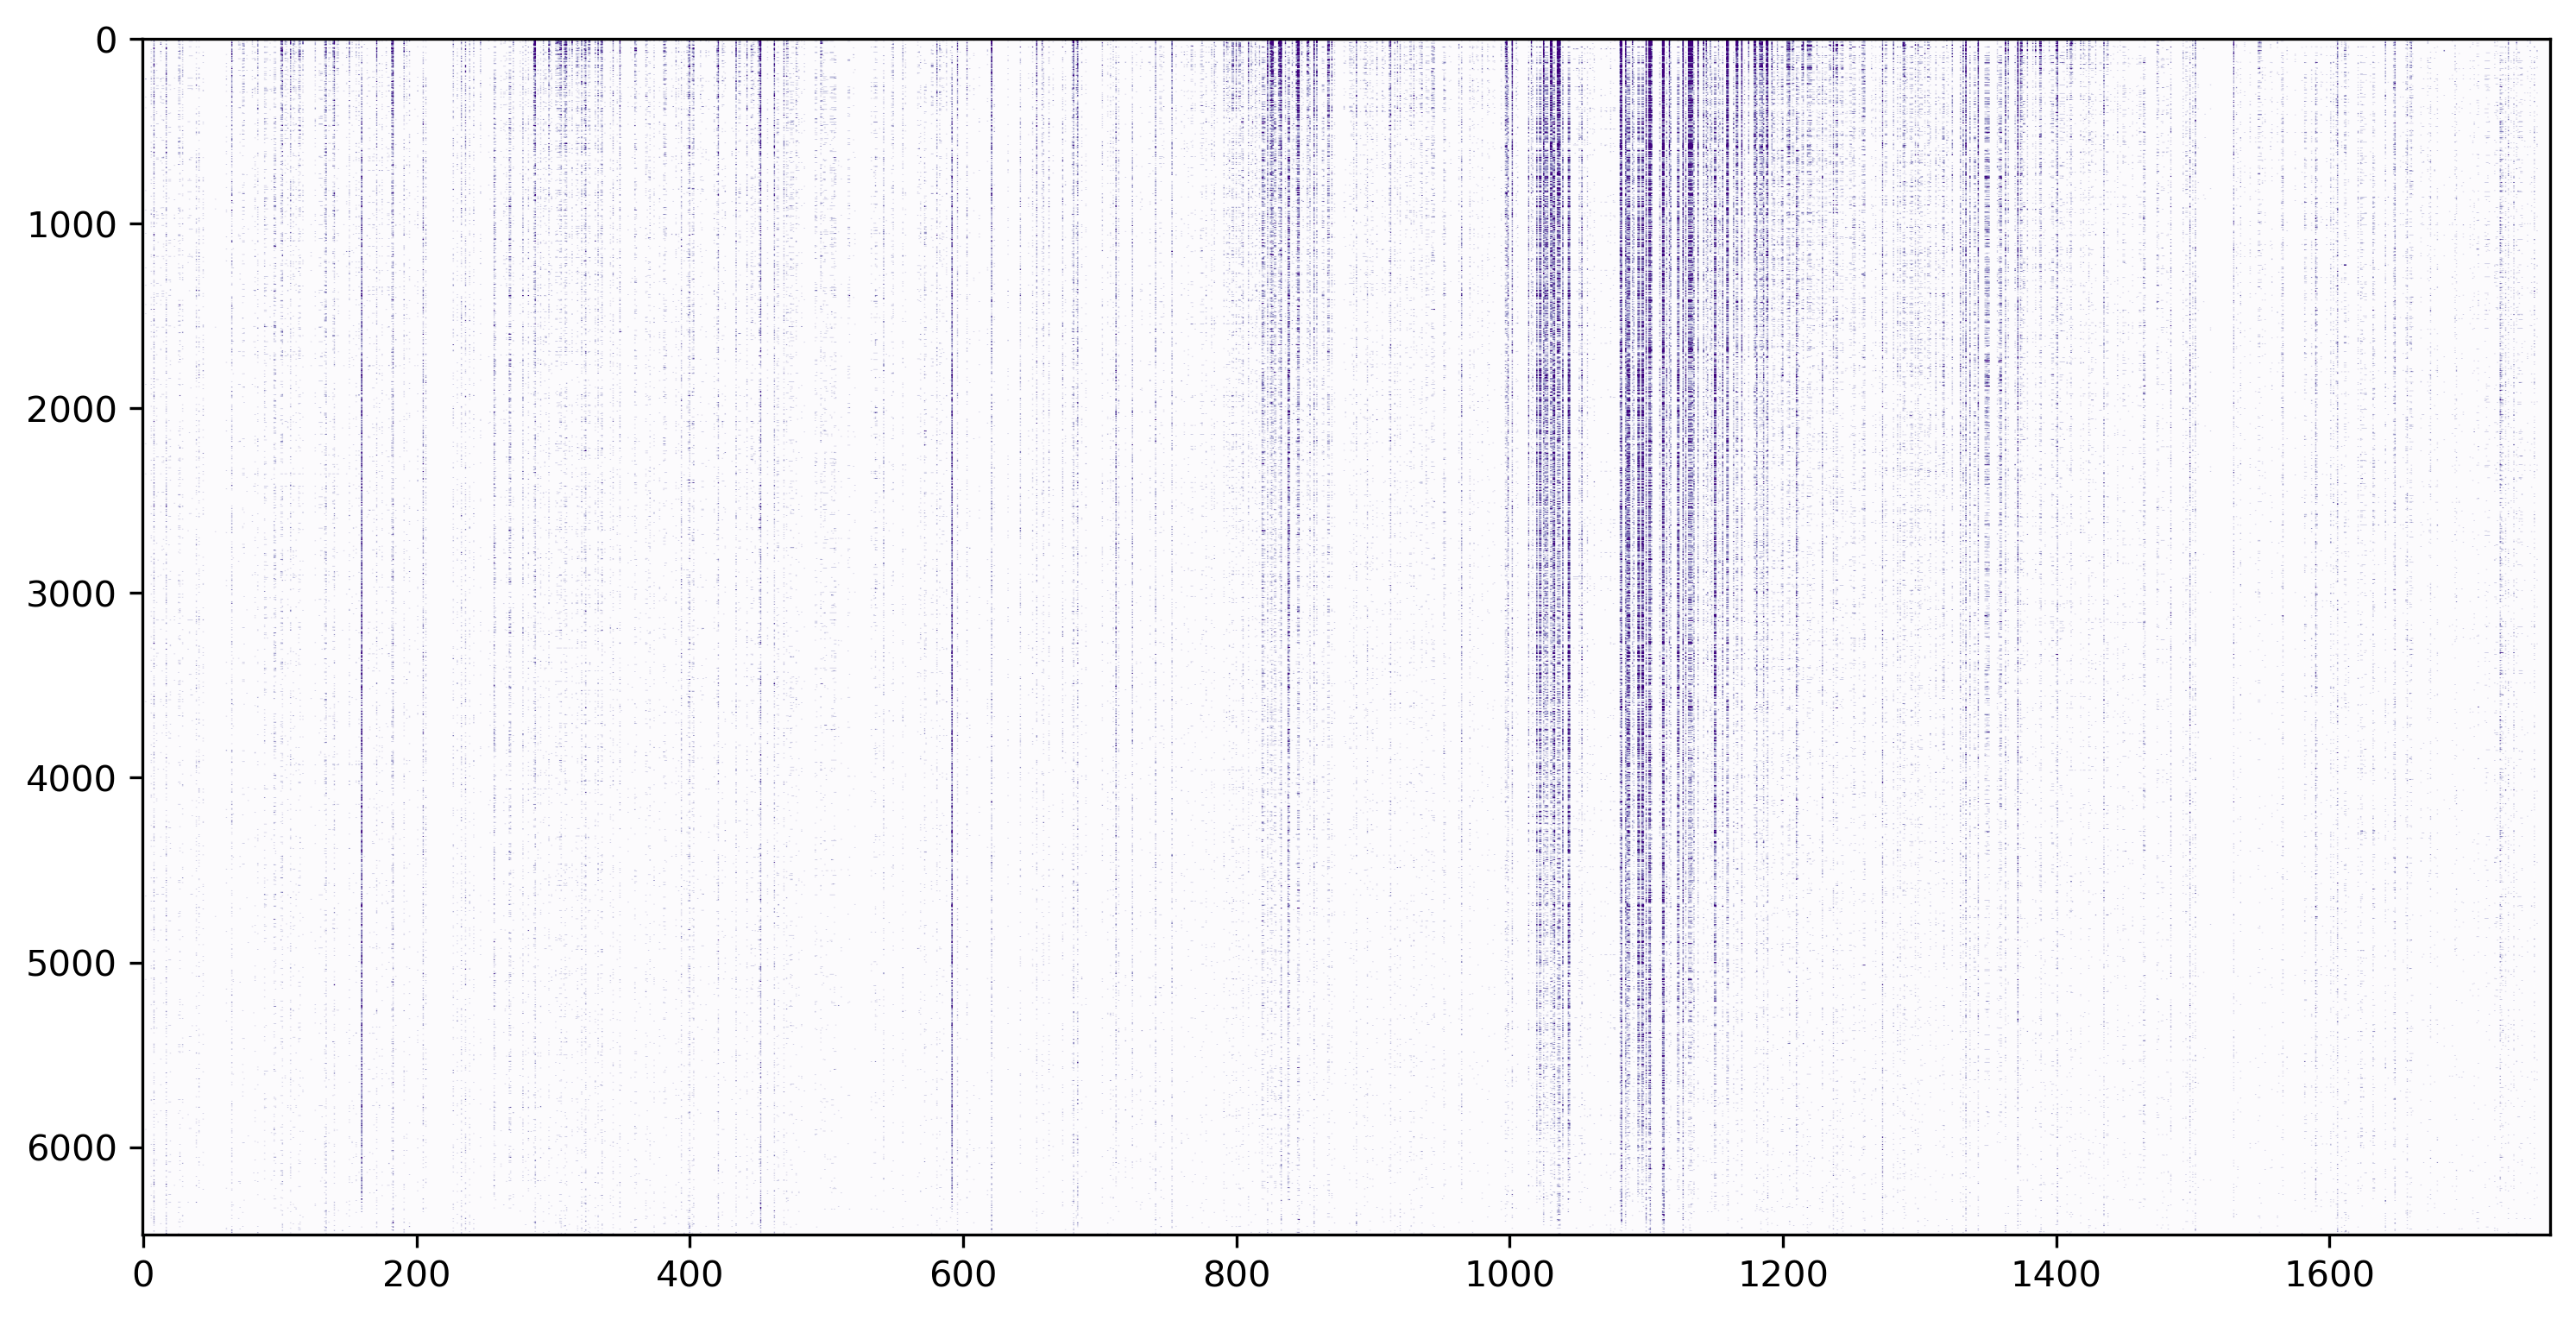

In [12]:
read_edit_num = np.sum(edits, axis=1)
plot_range = np.arange(500, 107423552-107420790-500)

fig, ax = plt.subplots(dpi=300, figsize=(12, 6))

undel_filter = np.where(selected_del_flags == 0)[0]
row_order = [i for i in np.argsort(-read_edit_num)]
ax.imshow(edits[row_order, :][:, plot_range], aspect='auto', vmax=0.7, vmin=0, cmap="Purples")

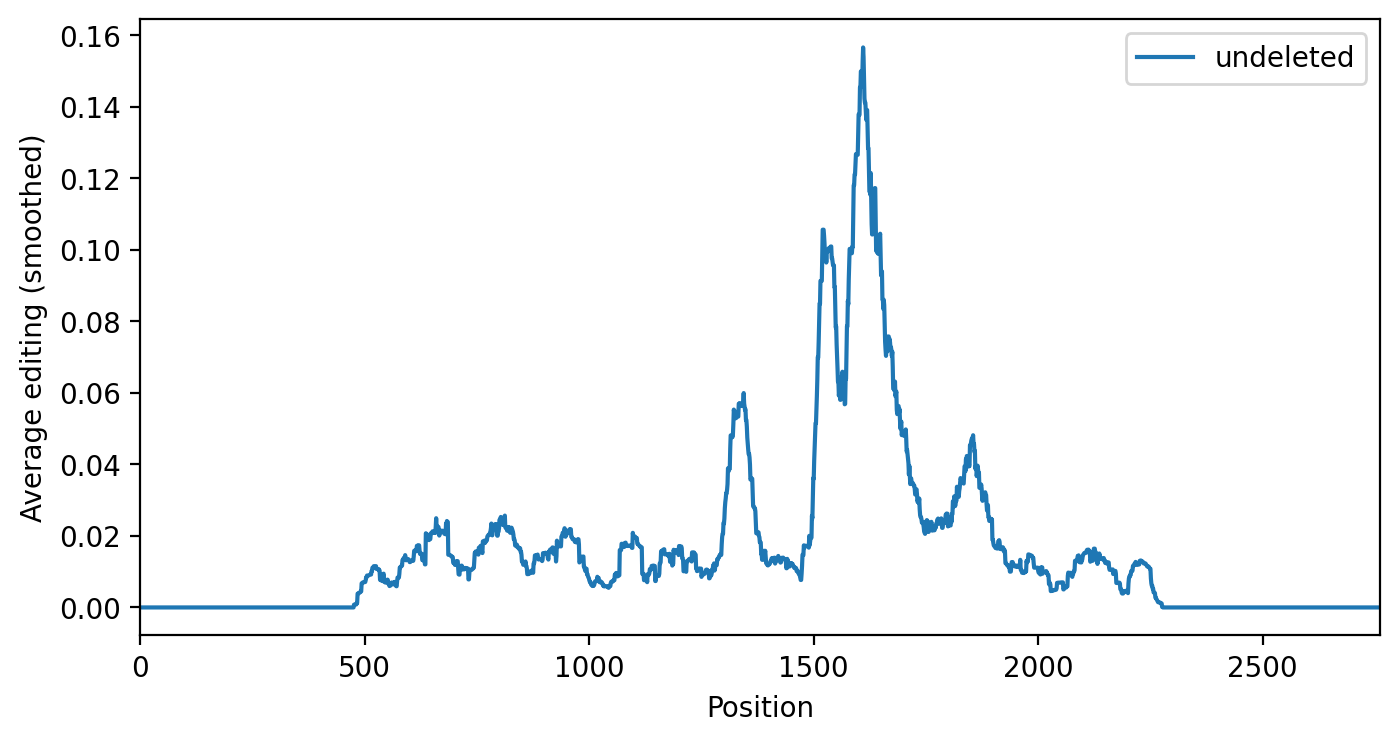

In [14]:
# Calculate average editing rate for each condition
track_undeleted_ac = np.mean(edits[np.array(selected_del_flags) == 0, :], axis = 0)

# Smooth tracks
track_undeleted_ac_smoothed = np.convolve(track_undeleted_ac, np.ones(50),mode='same')/50

# Visualize results
plt.figure(dpi=200, figsize=(8, 4))

plt.plot(np.arange(len(track_undeleted_ac_smoothed)), track_undeleted_ac_smoothed, label="undeleted")
plt.xlabel("Position")
plt.ylabel("Average editing (smoothed)")
plt.legend()
plt.xlim(0, len(track_undeleted_ac_smoothed) - 1)

plt.show()

In [19]:
plot_range = np.arange(500+800, 107423552-107420790-500-400)

track_undeleted_ac = np.mean(edits[np.array(selected_del_flags) == 0, :], axis = 0)
track_undeleted_ac = np.convolve(track_undeleted_ac, np.ones(50),mode='same')/50
track_undeleted_ac_zoomin =track_undeleted_ac[plot_range]

In [20]:
#sgRNA barplot
data_x_values = np.arange(ref_range_dict[locus][1], ref_range_dict[locus][2]+1)
bar_values = np.zeros_like(data_x_values)
bar_values[(data_x_values >= 107422338) & (data_x_values < 107422358)] = 3  # Adjust indices as needed

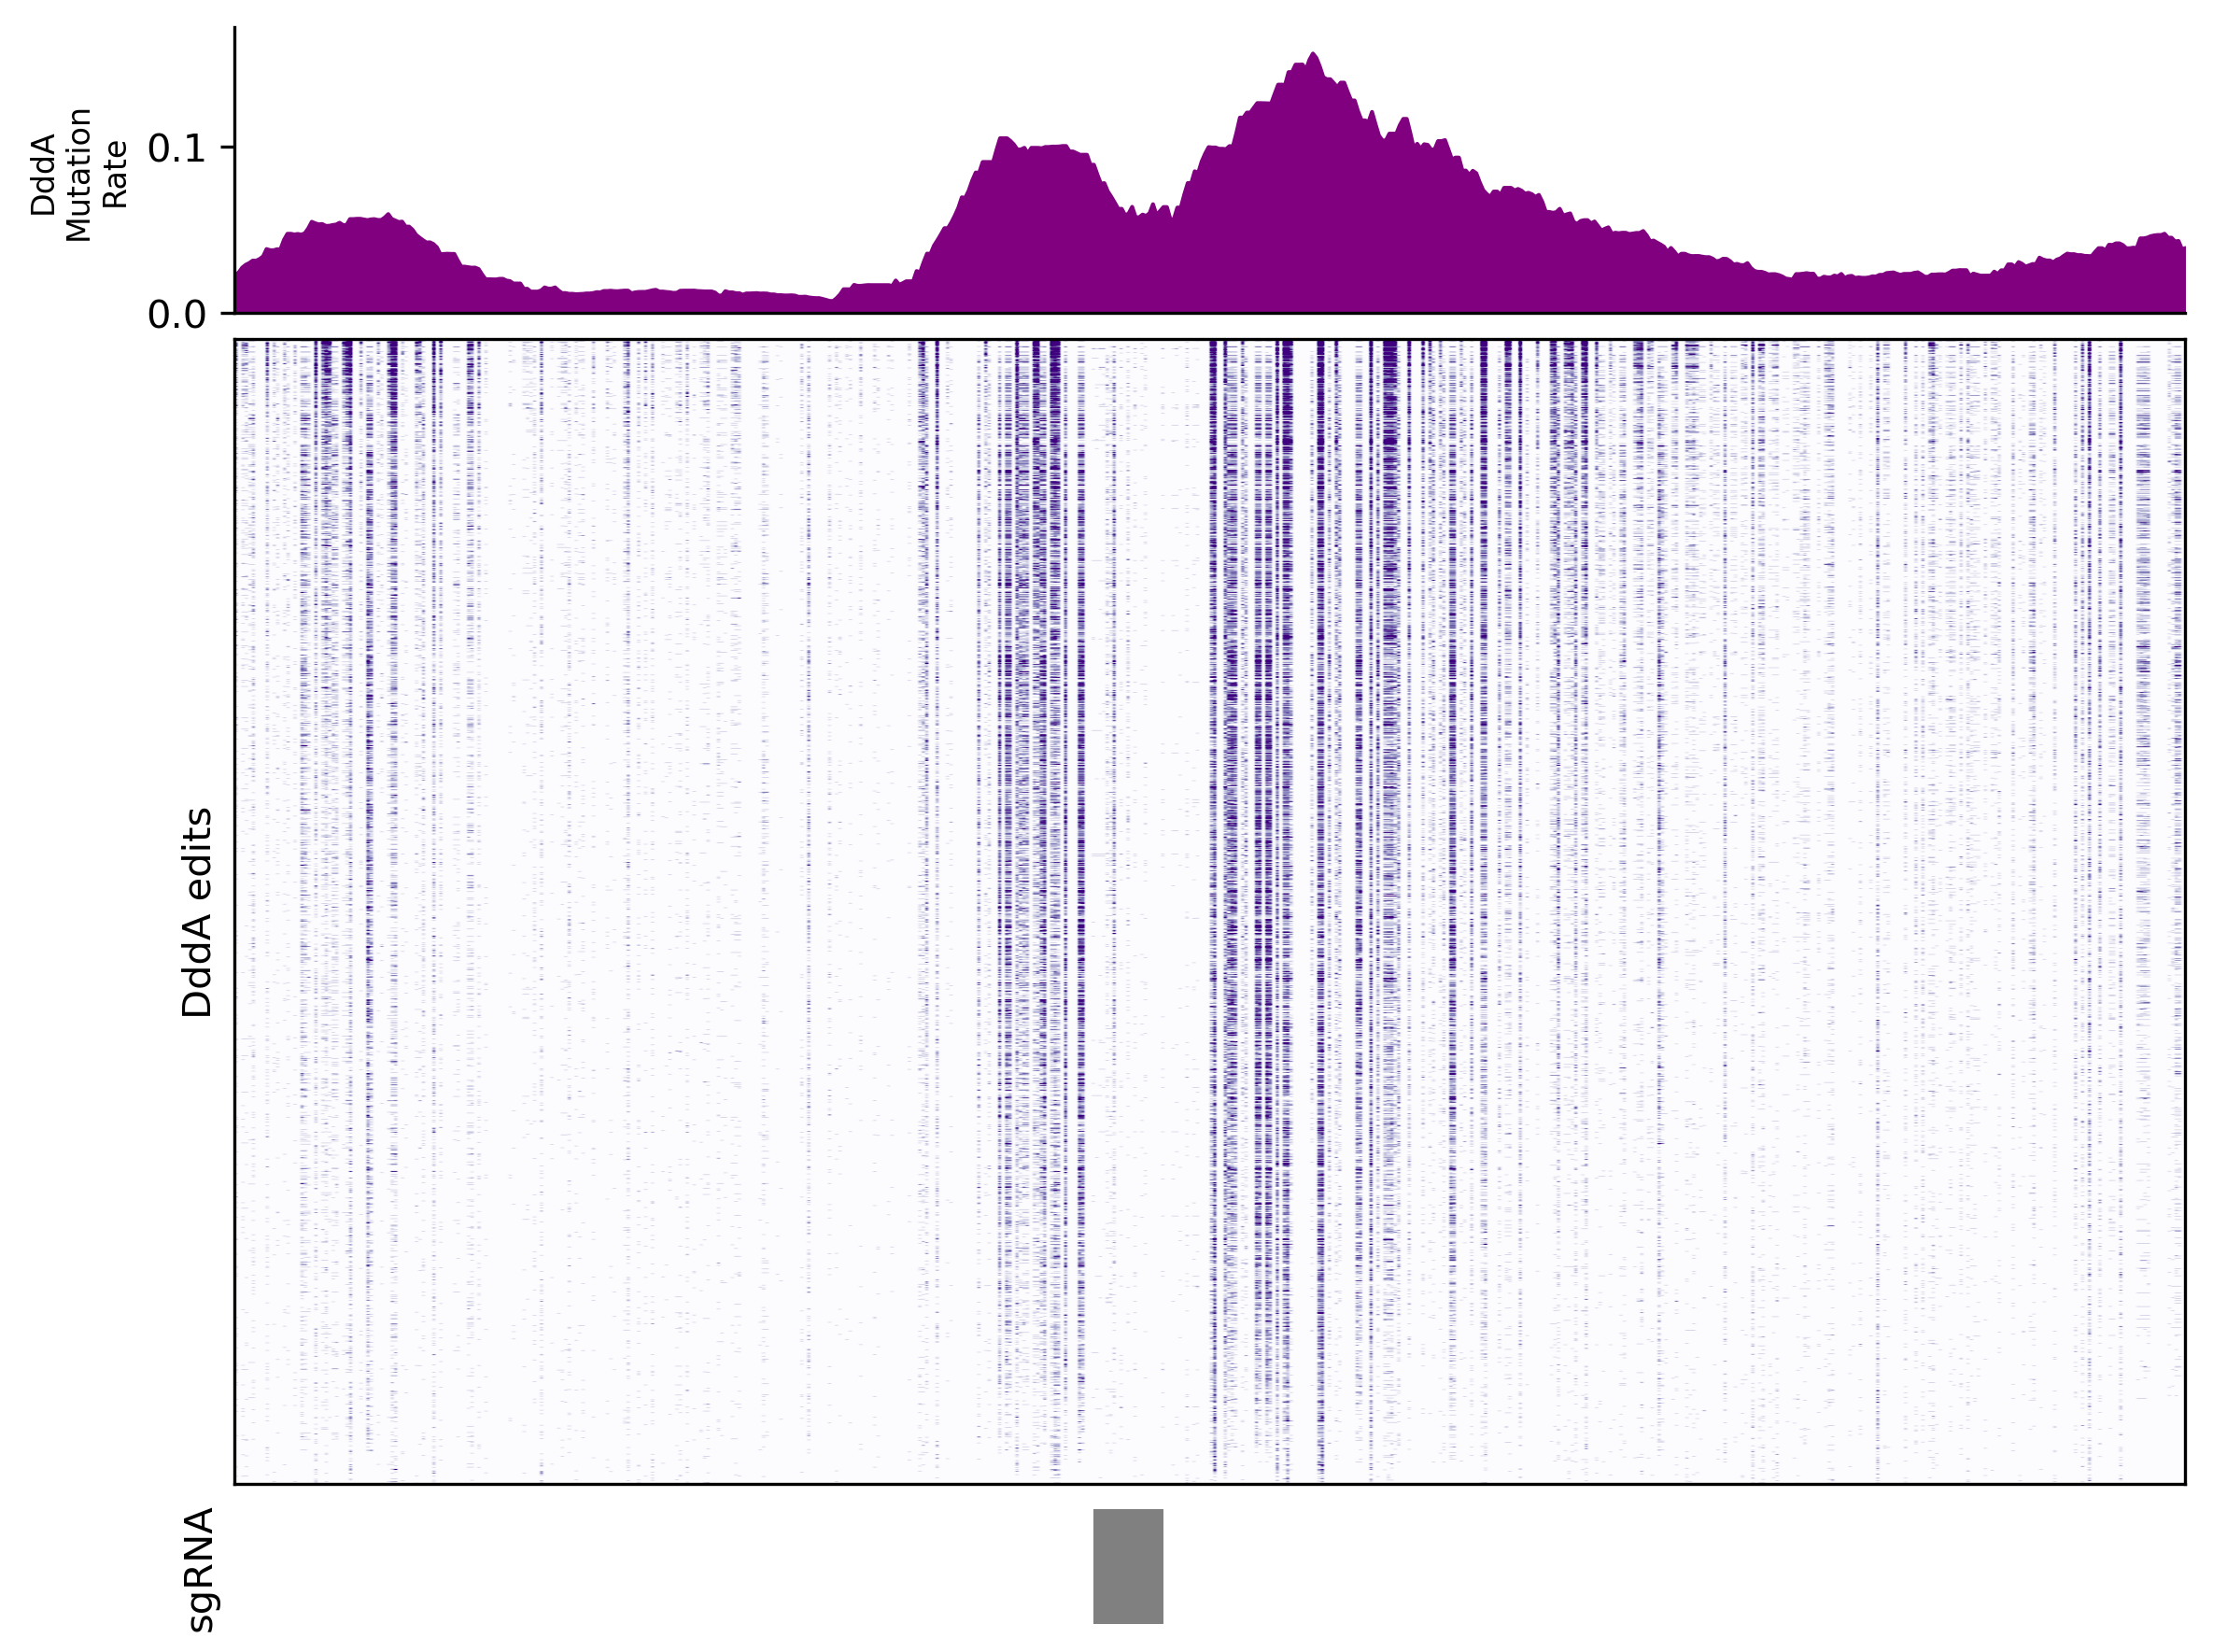

In [21]:
import matplotlib.gridspec as gridspec

fig = plt.figure(dpi=300,figsize=(8,6))  # Adjusted the figure size to accommodate four plots
gs = gridspec.GridSpec(3, 1, height_ratios=[0.5, 2, 0.2])  # Adjusted to four rows

# First subplot (now second)
ax3 = plt.subplot(gs[0])
x_values = np.arange(len(track_undeleted_ac_zoomin))
ax3.fill_between(x_values,track_undeleted_ac_zoomin, color='purple', alpha=1)
ax3.set_xlim([x_values.min(), x_values.max()])
ax3.set_ylim([0, max(track_undeleted_ac_zoomin) * 1.1])
ax3.set_xticks([])  # Remove x-axis ticks
ax3.set_xlabel('')
ax3.set_ylabel('DddA\nMutation\nRate', fontsize=8)

# Remove box outline and keep x and y axis
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)


edits = np.array(ddda_data.edit_dict[locus][selected_read_inds, :].todense())
undel_filter = np.where(selected_del_flags == 0)[0]
row_order = [i for i in np.argsort(-read_edit_num)]


# Second subplot (now third)
ax4 = plt.subplot(gs[1])
ax4.imshow(edits[row_order, :][:, plot_range], aspect='auto',vmax=0.7, vmin=0, cmap='Purples')
ax4.set_ylabel('DddA edits')
ax4.set_xticks([])  # Remove x-axis ticks
ax4.set_yticks([])  # Remove y-axis ticks
ax4.set_xlabel('')

ax5 = plt.subplot(gs[2])
ax5.bar(data_x_values[1300:-900], bar_values[1300:-900], color='grey', alpha=1, width=1.0)
ax5.set_xlim([data_x_values[1300:-900].min(), data_x_values[1300:-900].max()])
ax5.set_ylim([0, 3])  # Set y-axis limits for the bar plot
ax5.set_xticks([])  # Remove y-axis ticks for the bar plot
ax5.set_yticks([])  # Remove y-axis ticks for the bar plot
ax5.set_ylabel('sgRNA')

ax5.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)
ax5.spines['bottom'].set_visible(False)
ax5.spines['left'].set_visible(False)


plt.tight_layout()  # Adjust layout
plt.subplots_adjust(hspace=0.05)  # Adjust space between plots

plt.savefig('/n/holystore01/LABS/liau_lab/Users/heejinroh/Yan_minimap/analysis/HJR231/HJR231_1_zoomin.pdf', format='pdf')

plt.show()


